# Machine learning bank's credit card service churn prediction
In this project, I will build a <b>machine learning model to predict customer's probability of churning in a bank's credit card service.</b> It involves <b>supervised learning (using a labeled training set) for classification</b>, where the <b>target</b> is <b>1</b> if the <b>customer churned</b>, else <b>0.</b>

I will use the following <b>pipeline</b> based on <b>CRISP-DM framework:</b>

<b>1. Define the business problem.</b><br>
<b>2. Collect the data and get a general overview of it.</b><br>
<b>3. Split the data into train and test sets.</b><br>
<b>4. Explore the data (exploratory data analysis)</b><br>
<b>5. Data cleaning and preprocessing.</b><br>
<b>6. Model training, comparison, selection and tuning.</b><br>
<b>7. Final production model testing and evaluation.</b><br>
<b>8. Conclude and interpret the model results.</b><br>
<b>9. Deploy.</b><br>

In <b>this notebook</b>, I will perform <b>machine learning modelling, covering steps 5 to 8 of the pipeline above.</b> The main <b>objective</b> here is to <b>build a model that can predict as many churners as possible, thus recall is the metric of interest.</b> Once I build this model, the <b>bank can plan strategies for client retention, maintaining healthy revenue. Acquiring new customers is costlier than keeping existing ones.</b> Furthermore, I will approach these steps in detail below, explaining why I am making each decision.

### Importing the libraries

In [6]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.base import clone

# Fixing bayesian search error.
np.int = int

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

# Utils
from notebooks.modelling_utils import *

### Reading the dataset

In [7]:
df = pd.read_csv('data/BankChurners.csv')

# Features that must be dropped.
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'], inplace=True)

In [8]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


- I will drop the CLIENTNUM variable because it has an unique value for each record, not being useful for the analysis.
- I will rename the columns in a standard format in order to turn the data manipulation easier. Moreover, attrition_flag will be renamed as churn_flag for interpretation purposes.
- I will express Gender and Attrition_Flag variables as binary. This will make eda easier, like when looking at percentual values.

In [9]:
df.drop(columns=['CLIENTNUM'], inplace=True)

In [10]:
df.columns = [x.lower() for x in df.columns]

In [11]:
df['gender'] = df['gender'].map({'M': 1, 'F': 0})
df['attrition_flag'] = df['attrition_flag'].map({'Attrited Customer': 1, 'Existing Customer': 0})

In [12]:
df.rename(columns={'attrition_flag': 'churn_flag'}, inplace=True)

### Split the data into train and test sets
- First of all, I will split the data into train and test sets.
- Test set is supposed to be data the model has never seen before.
- This split will avoid data leakage, which occurs when information from the test set or future data inadvertently leaks into the training process, leading to over-optimistic performance estimate, compromising the model's ability to generalize to new, unseen data.
- A good practice to protect the model against data leakage is perform fit_transform on training data and just transform on test data when applying preprocessing steps after the split.
- I will specify stratify=y so that the train_test_split function ensures that the splitting process maintains the same percentage of each target class in both the training and testing sets. This is particularly useful when dealing with imbalanced datasets, which is the case, as there are more existing customers than attrited ones.

In [13]:
X = df.drop(columns=['churn_flag'])
y = df['churn_flag'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [14]:
print(f'Train predictor dataset shape: {X_train.shape}.')
print(f'Train target dataset shape: {y_train.shape}.')
print(f'Test predictor dataset shape: {X_test.shape}.')
print(f'Test target dataset shape: {y_test.shape}.')

Train predictor dataset shape: (8101, 19).
Train target dataset shape: (8101,).
Test predictor dataset shape: (2026, 19).
Test target dataset shape: (2026,).


In [15]:
print(f'Train target proportion: ')
print(f'{y_train.value_counts(normalize=True)}')
print(f'\nTest target proportion: ')
print(f'{y_test.value_counts(normalize=True)}')

Train target proportion: 
churn_flag
0    0.839279
1    0.160721
Name: proportion, dtype: float64

Test target proportion: 
churn_flag
0    0.839585
1    0.160415
Name: proportion, dtype: float64


The target classes proportions were preserved.

# 5. Data cleaning and preprocessing
In order to fit machine learning algorithms, it is necessary to apply some transformations to the data.
- <b>Impute missing values:</b> The dataset doesn't have missing values. So it will not be necessary to impute any.
- <b>Outliers:</b> In the eda step, I investigated the outliers and saw they don't represent inconsistent information like measurement errors. Thus, considering this and the fact that they carry valuable information for the model, I will not drop or treat any.
- In order to train tree-based algorithms, it is not necessary to scale the data. However, as I intend to test different algorithms, I will apply standard scaler on numerical and categorical features (after encoding). By doing this, it will be possible to compare all models at once.
- <b>Numerical features:</b> Some algorithms are sensitive to feature scaling because they use distance calculations or optimizations like gradient descent for being trained, which are affected by scale. Thus, I will apply StandardScaler on numeric attributes (it is more robust to outliers than MinMaxScaler, which uses range).
- <b>Categorical features:</b> Machine learning algorithms make mathematical calculations, so it's necessary to convert the categoric attributes to numeric by applying encoding techniques. Education level, income category, and card category present ordinal relationships. Thus, I will choose OrdinalEncoder for encoding them, in order to preserve this behavior. Moreover, once OneHotEncoder might be harmful for tree-based models (because of increased dimensionality and sparse representation) and favor overfitting, I will apply TargetEncoder on marital status. After all these variables are encoded/converted to numeric, I will apply StandardScaler because, as I've mentioned above, I intend to test a bunch of models at once, and some of them are sensitive to scale.
- Once the proportions of the 'Unknown' category within education level, income category, and marital status are low, and these variables seem to have a minimal effect on the dependent variable (I verified this on the EDA step), I will leave it untreated.

In [16]:
X_train.head()

,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
2856,36,0,0,Unknown,Married,Less than $40K,Blue,24,4,3,2,2570.0,2230,340.0,0.686,1755,42,0.448,0.868
6515,44,1,3,High School,Single,$60K - $80K,Silver,36,5,2,3,25276.0,0,25276.0,0.849,2282,38,0.583,0.000
7141,46,1,2,High School,Married,$80K - $120K,Blue,30,6,3,1,11670.0,915,10755.0,0.892,4277,89,0.854,0.078
632,36,0,2,Graduate,Married,Less than $40K,Blue,24,3,1,3,3124.0,1593,1531.0,0.869,1652,41,0.367,0.510
3496,50,1,1,Graduate,Single,$120K +,Blue,40,4,2,3,34516.0,1185,33331.0,0.725,3874,72,0.714,0.034


Checking missing values.

In [17]:
X_train.isna().sum()

customer_age                0
gender                      0
dependent_count             0
education_level             0
marital_status              0
income_category             0
card_category               0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
contacts_count_12_mon       0
credit_limit                0
total_revolving_bal         0
avg_open_to_buy             0
total_amt_chng_q4_q1        0
total_trans_amt             0
total_trans_ct              0
total_ct_chng_q4_q1         0
avg_utilization_ratio       0
dtype: int64

Checking numerical features.

In [18]:
numerical_features = X_train.select_dtypes('number').columns.to_list()
print(f'There are {len(numerical_features)} numerical features.')
print('They are:')
print(numerical_features)

There are 15 numerical features.
They are:
['customer_age', 'gender', 'dependent_count', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon', 'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal', 'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt', 'total_trans_ct', 'total_ct_chng_q4_q1', 'avg_utilization_ratio']


Checking categorical features cardinality and unique values.

In [19]:
categorical_features = X_train.select_dtypes('object').columns.to_list()
print(f'There are {len(categorical_features)} categorical features.')
print('They are: ')
print(categorical_features)

There are 4 categorical features.
They are: 
['education_level', 'marital_status', 'income_category', 'card_category']


In [20]:
for feature in categorical_features:
    print(feature)
    print('-'*40)
    print(f'There are {X_train[feature].nunique()} unique values. They are: ')
    print(X_train[feature].value_counts(normalize=True))
    print()

education_level
----------------------------------------
There are 7 unique values. They are: 
education_level
Graduate         0.306382
High School      0.203679
Unknown          0.148994
Uneducated       0.146031
College          0.098259
Post-Graduate    0.052710
Doctorate        0.043945
Name: proportion, dtype: float64

marital_status
----------------------------------------
There are 4 unique values. They are: 
marital_status
Married     0.463523
Single      0.387853
Unknown     0.074682
Divorced    0.073941
Name: proportion, dtype: float64

income_category
----------------------------------------
There are 6 unique values. They are: 
income_category
Less than $40K    0.349586
$40K - $60K       0.178990
$80K - $120K      0.149241
$60K - $80K       0.140230
Unknown           0.109369
$120K +           0.072584
Name: proportion, dtype: float64

card_category
----------------------------------------
There are 4 unique values. They are: 
card_category
Blue        0.933095
Silver     

I will build the preprocessor below, following the techniques I have mentioned above.

In [21]:
target_encoder_feature = ['marital_status']
ordinal_encoder_features = list(filter(lambda x: x != 'marital_status', categorical_features))

In [22]:
ordinal_pipeline = Pipeline(
    steps=[
        ('ordinal_encoder', OrdinalEncoder()),
        ('std_scaler', StandardScaler())
    ]
)

target_pipeline = Pipeline(
    steps=[
        ('target_encoder', TargetEncoder(cols=target_encoder_feature)),
        ('std_scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_pipeline, ordinal_encoder_features),
        ('target', target_pipeline, target_encoder_feature),
        ('std_scaler', StandardScaler(), numerical_features)
    ], remainder='passthrough'
)

In [23]:
X_train_prepared = preprocessor.fit_transform(X_train, y_train)
X_train_prepared.shape

(8101, 19)

# 6. Model training, comparison, selection and tuning
- In this step, I intend to compare different models performances. In order to achieve this, I will use stratified k-fold cross validation to train each one of them and evaluate their ROC-AUC score. Accuracy is not a good metric because the target is imbalanced. Moreover, stratified k-fold cross validation will maintain the target proportion on each fold, dealing with the imbalanced target as well.
- <b>K-fold cross-validation</b> is a technique used in machine learning to assess the performance of a model. It involves dividing the dataset into K subsets, using K-1 for training and one for testing iteratively. This helps in estimating a model's generalization ability by reducing the risk of overfitting and providing more reliable performance metrics.
- My objective here is to select a best model to go for hyperparameter tuning. In order to get this best model, I will evaluate the highest roc-auc average validation scores and look at the bias-variance trade-off.
- After selecting a model, I will tune its hyperparameters.
- <b>Hyperparameter tuning</b> refers to the process of selecting the optimal hyperparameters for a machine learning model. Hyperparameters are parameters that are set before the model is trained and directly influence its performance but are not learned from the data.

Training the models and comparing their performances (roc-auc score) with stratified k-fold cross validation in order to choose one of them for hyperparameter tuning.

In [24]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear SVM': LinearSVC(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

Logistic Regression results: 
--------------------------------------------------
Training score: 0.7774691950045061
Average validation score: 0.9246184502141572
Standard deviation: 0.0067341895575112175
Training time: 0.05653 seconds



Linear SVM results: 
--------------------------------------------------
Training score: 0.7738005995731277
Average validation score: 0.9239775051780887
Standard deviation: 0.006749305734186676
Training time: 0.51643 seconds

SVM results: 
--------------------------------------------------
Training score: 0.8693740879486885
Average validation score: 0.9646058713376107
Standard deviation: 0.003675693481127849
Training time: 0.67797 seconds

K-Nearest Neighbors results: 
--------------------------------------------------
Training score: 0.8217959336660379
Average validation score: 0.893980077704563
Standard deviation: 0.009623366108436573
Training time: 0.0 seconds

Random Forest results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.9878756152418775
Standard deviation: 0.0032297849807364346
Training time: 2.20704 seconds

XGBoost results: 
--------------------------------------------------
Training score: 1.0
Average validation score:

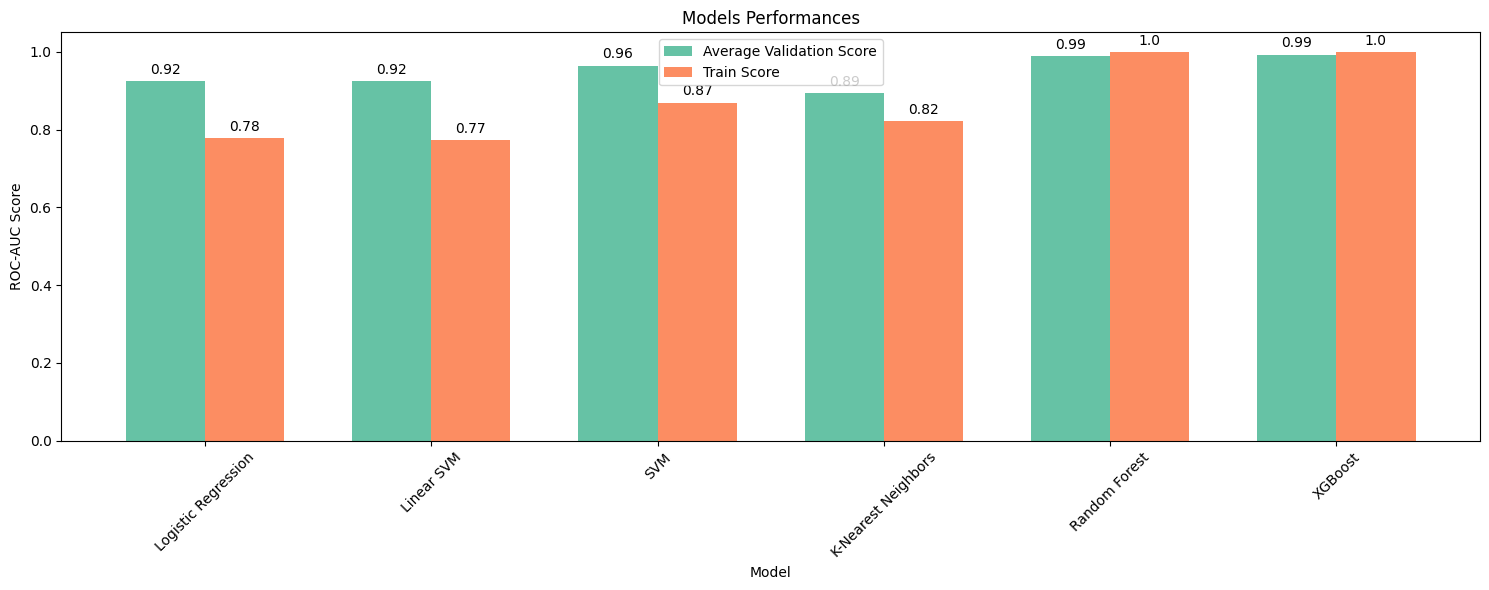

In [25]:
eval_df = evaluate_models_cv(models, X_train_prepared, y_train)

In [26]:
eval_df.sort_values(['Average Val Score'], ascending=False)

,Model,Average Val Score,Train Score
5,XGBoost,0.992704,1.000000
4,Random Forest,0.987876,1.000000
2,SVM,0.964606,0.869374
0,Logistic Regression,0.924618,0.777469
1,Linear SVM,0.923978,0.773801
3,K-Nearest Neighbors,0.893980,0.821796


The results are great. I will go with XGBoost for hyperparameter tuning and final model evaluation because it presents the highest average validation ROC-AUC score.

### Hyperparameter tuning
As I intend to tune XGBoost model, I won't use GridSearchCV.

<b>Why not use grid search?</b> 
- Using grid search CV to tune XGBoost can be problematic due to its computational expense, limitations in granularity and adaptability, lack of consideration for interaction effects, inefficient exploration of the hyperparameter space, and inefficient allocation of computational resources. 
- Grid search exhaustively searches through all combinations of specified hyperparameters, it does not adapt its search based on the observed performance of previous hyperparameter configurations. Also, hyperparameters in XGBoost can have complex interactions, where the impact of one hyperparameter depends on the values of others (like learning rate and number of estimators). Grid search does not explicitly consider these interactions and evaluates hyperparameters independently. 
- As a result, more advanced optimization methods such as randomized search and Bayesian Optimization are often preferred for more efficient and effective hyperparameter tuning with XGBoost.<br>

Considering this, I will tune XGBoost using Bayesian Optimization.

<b>What is Bayesian Optimization?</b>
-  Bayesian optimization is an efficient and adaptive technique for finding the optimal combination of hyperparameters for a machine learning model. It uses probabilistic models to intelligently explore the hyperparameter space, balancing exploration and exploitation.

An important point here is to define class_weight hyperparameter. Then, the algorithm will assign different weights for the target's minority (attrited) and majority (existing) class instances. Thus, the model will be penalized when mistakenly predicting a churner and also be able to better learn the patterns in minority class data samples.

In [27]:
n_folds = 5
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

search_space = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(2,16),
    'learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'min_child_weight': Integer(1,10),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'lambda': Real(0.0, 10.0),
    'gamma': Real(0.0, 10.0),
    'scale_pos_weight': Integer(1, 10)
}

bayesian_search = BayesSearchCV(XGBClassifier(), search_space, cv=stratified_kfold, n_iter=50, 
                                scoring='roc_auc', return_train_score=True, random_state=1) 

In [28]:
bayesian_search.fit(X_train_prepared, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_ty...
                             'max_depth': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                             'scale_pos_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [29]:
print(f'The best params fund for XGBoost are: ')
bayesian_search.best_params_

The best params fund for XGBoost are: 


OrderedDict([('colsample_bytree', 0.6990559033956983),
             ('gamma', 9.029710156344564),
             ('lambda', 2.3076689805633372),
             ('learning_rate', 0.12498672387208519),
             ('max_depth', 4),
             ('min_child_weight', 3),
             ('n_estimators', 500),
             ('scale_pos_weight', 10),
             ('subsample', 0.7541369107532966)])

Let's take a look into some results obtained by the bayesian search cv, specially for important parameters, like lambda, learning_rate, max_depth, min_child_weight, n_estimators and scale pos weight.

In [30]:
bayesian_search_results = pd.DataFrame(bayesian_search.cv_results_)
bayesian_search_results = bayesian_search_results[['rank_test_score','mean_test_score',
                                                   'mean_train_score', 'param_lambda',
                                                   'param_learning_rate', 'param_max_depth', 
                                                   'param_min_child_weight', 'param_n_estimators',
                                                   'param_scale_pos_weight']]
bayesian_search_results.sort_values(['rank_test_score']).head(10)

,rank_test_score,mean_test_score,mean_train_score,param_lambda,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_scale_pos_weight
45,1,0.993266,0.999009,2.307669,0.124987,4,3,500,10
9,2,0.993157,0.999432,6.257396,0.167567,14,4,393,9
8,3,0.993023,0.999251,8.662479,0.109678,8,5,234,9
33,4,0.993016,0.999702,0.0,0.038719,16,10,500,5
4,5,0.992998,0.999932,0.258013,0.051581,9,5,395,6
12,6,0.992753,1.000000,0.0,0.054345,16,1,500,10
23,7,0.992655,0.999916,0.507272,0.158236,13,4,106,1
37,8,0.992582,0.999776,0.0,0.040809,5,10,500,10
47,9,0.992554,0.998515,2.409914,0.017128,13,4,487,5
44,10,0.992518,0.999367,0.847501,0.02069,6,2,500,4


### 7. Final production model testing and evaluation
- In this step, I intend to evaluate our final tuned model on test data (simulating production unseen data).
- Once I am facing a binary classification problem with an imbalanced target, recall is the most important metric. I want my model to identify as many churners as possible.
- Furthermore, I will examine the precision-recall trade-off to determine whether there is room for improvement in the recall metric without significantly compromising the precision score. This is a sound strategy when dealing with imbalanced data. Additionally, I will assess whether the potential improvement in predicting customer churn by comparing probabilities with a threshold is worthwhile. The primary objective is to generate probability scores for each customer, which is generally more valuable for businesses compared to making binary predictions (1/0). This approach enhances decision-making and allows for more effective customer retention strategies.

Getting the final tuned XGBoost model.

In [31]:
final_xgb_clf = bayesian_search.best_estimator_

Using the preprocessor to transform the test predictor set. By applying just transform we avoid data leakage.

In [32]:
X_test_prepared = preprocessor.transform(X_test)
X_test_prepared.shape

(2026, 19)

Making predictions.

In [33]:
final_predictions = final_xgb_clf.predict(X_test_prepared)

Getting the model's estimated probabilities of churn for roc-auc curve.

In [34]:
probas = final_xgb_clf.predict_proba(X_test_prepared)[:, 1]

### Evaluating the final tuned XGBoost model.

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1701
           1       0.85      0.94      0.89       325

    accuracy                           0.96      2026
   macro avg       0.92      0.95      0.93      2026
weighted avg       0.97      0.96      0.96      2026



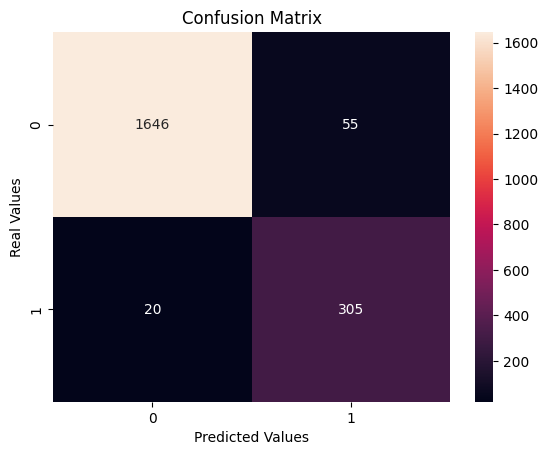

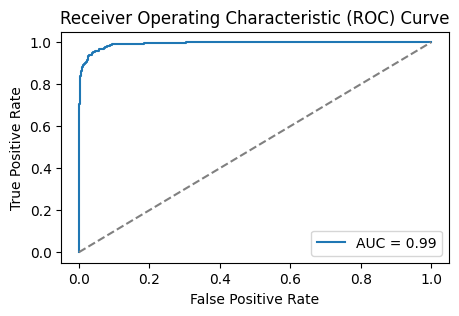

In [35]:
evaluate_classifier(y_test, final_predictions, probas)

The model results are excellent!

<b>Recall (0.94):</b> The model correctly identifies 94% of the churners. In practical terms, looking at the confusion matrix, it has accurately predicted 305 out of 325 attrited customers.<br>
<b>Precision (0.85):</b> Out of all customers predicted as churn, 85% of them are actually churners. In practical terms, considering the confusion matrix, out of 360 customers predicted as churn, 305 of them are indeed churners.<br>
<b>ROC-AUC (0.99):</b> With a ROC-AUC score of 0.99, the model demonstrates outstanding ability to differentiate between attrited and existing customers.

### Interpreting the model results with feature importances
- I will look at <b>feature importances</b> below in order to interpret XGBoost outcomes. An important task when performing supervised learning on a dataset is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do.
- XGBoost calculates feature importances by measuring the total reduction in the loss function achieved by each feature when it is used in splitting the decision trees during the boosting process.

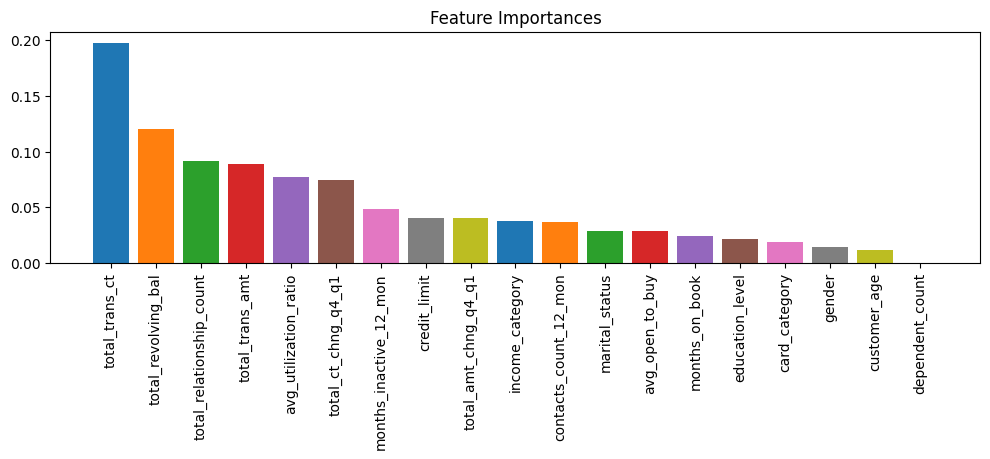

In [36]:
plot_feature_importances(final_xgb_clf, X_train)

The model results are coherent! It's evident that the same features we identified as the most useful ones during the EDA step have the highest predictive power. Some of these features include total transaction count, total revolving balance, total relationship count, total transaction amount, average utilization ratio, and total count change. Therefore, everything makes sense!

### Precision-recall trade-off
- I will examine the precision-recall trade-off in order to see if there is room for recall metric enhancement without compromising too much the precision score. The objective here is to predict as many churners as possible, making this an important task to perform.
- The precision-recall trade-off involves finding a balance between precision (accuracy of positive predictions) and recall (coverage of actual positives) in a classification model, where improving one often comes at the expense of the other.

Getting the entire model's estimated probabilities.

In [37]:
predicted_probas = final_xgb_clf.predict_proba(X_test_prepared)

Plotting precision-recall curve for different threshold values.

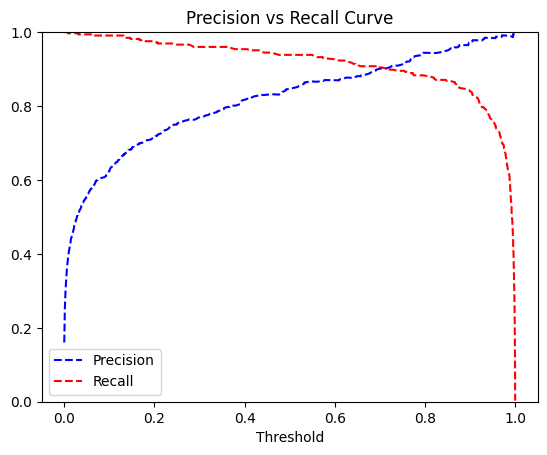

In [38]:
precision, recall, threshold = precision_vs_recall_curve(y_test, predicted_probas)

Getting the threshold for a 0.96 recall score.

In [39]:
threshold_precision, threshold_recall, selected_threshold = get_threshold_metrics(precision=precision, 
recall=recall, threshold=threshold, 
target_metric='recall', target_metric_value=0.96)

For a threshold of 0.2867737114429474:
Recall: 0.96
Precision: 0.7628361858190709


Making predictions comparing the model's estimated churn probabilities with the threshold. If the probability is greater than the threshold, the instance is classified as positive, else negative.

In [40]:
threshold_predictions = (predicted_probas[:, 1] >= selected_threshold).astype(int)

Evaluating final model after balancing the precision-recall trade-off.

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1701
           1       0.76      0.96      0.85       325

    accuracy                           0.95      2026
   macro avg       0.88      0.95      0.91      2026
weighted avg       0.96      0.95      0.95      2026



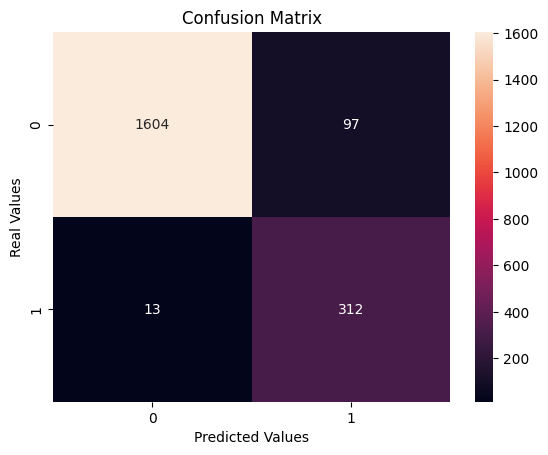

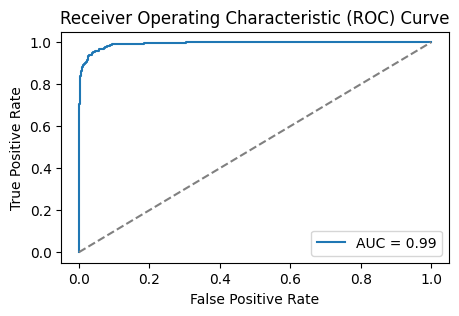

In [41]:
evaluate_classifier(y_test, threshold_predictions, predicted_probas[:, 1])

- By dealing with precision-recall trade-off, I was able to select a threshold value that improved the recall metric from 0.94 to 0.96. However, the precision score fell down from 0.85 to 0.76.
- Given that generating probability scores for each customer is typically more valuable for businesses than making binary predictions (1/0), as it enables better decision-making and more effective customer retention strategies, and considering that the recall increased by only 0.2 while precision decreased by 0.9, I have decided not to use the threshold for predictions and not to balance the precision-recall trade-off.

### Visualizing some probabilities
- I will take a look at some model's estimated churn probabilities below to asses the behaviors of attrited and existing customers, confirming EDA and feature importances results.

In [42]:
probas_df = pd.concat([X_test, y_test], axis=1)
probas_df['churn_probas'] = predicted_probas[:, 1]
probas_df.sample(10, random_state=42)

,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,...,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,churn_flag,churn_probas
5000,40,0,2,Graduate,Unknown,Less than $40K,Blue,29,5,1,...,2636.0,1953,683.0,0.916,4584,70,0.591,0.741,0,0.000486
1128,50,1,2,Graduate,Married,$80K - $120K,Blue,37,3,1,...,3126.0,0,3126.0,0.824,1388,41,0.464,0.000,0,0.366415
4540,39,0,1,Graduate,Single,Less than $40K,Blue,26,3,3,...,1876.0,1536,340.0,0.712,2579,47,0.469,0.819,1,0.989432
6229,45,0,5,Graduate,Married,Less than $40K,Blue,36,4,1,...,2289.0,1037,1252.0,0.504,4483,72,0.500,0.453,0,0.000779
10103,51,1,1,High School,Married,$80K - $120K,Blue,36,4,3,...,22754.0,0,22754.0,0.799,8531,77,0.791,0.000,1,0.991824
6993,33,1,1,High School,Divorced,$40K - $60K,Blue,28,6,1,...,2507.0,1592,915.0,0.691,4355,79,0.837,0.635,0,0.000011
2315,40,0,3,High School,Unknown,Less than $40K,Blue,31,5,2,...,2222.0,1551,671.0,0.932,3302,65,0.585,0.698,0,0.003083
9911,35,1,3,Graduate,Married,$60K - $80K,Blue,36,4,1,...,19671.0,924,18747.0,0.820,13908,124,0.676,0.047,0,0.000581
7809,37,0,2,High School,Single,Unknown,Blue,36,3,2,...,2346.0,1621,725.0,0.613,4287,79,0.717,0.691,0,0.000036
9293,38,0,2,Uneducated,Married,Less than $40K,Blue,36,2,3,...,7825.0,0,7825.0,0.724,14326,100,0.786,0.000,0,0.007019


### Financial results
- I will express the model's performance in terms of financial results for the bank in order to show that the project is worth it. I will do this looking at the confusion matrix and our current data.
- I don't have access to specific data to obtain the exact financial gain. However, a common revenue source for credit card companies is charging fees on the outstanding balance, known as the total revolving balance, which cardholders carry from month to month. Thus, I will assume the bank's fee is 18% (a common value) and calculate the financial gain with it.
- Considering this, in order to estimate the financial gain provided by the model, I will take into account the following costs and benefits:
    1. Retention cost per client (false positive):
        - This cost applies to customers who wouldn't churn but were misclassified as churners by the model, leading the bank to incur expenses in retaining them. Specifically, to retain the customer, I will offer a discount on the fee, reducing it from 18% to 10%, resulting in a loss of revenue due to this 8% discount. 
    2. Revenue loss per churner (false negative):
        - This cost arises when customers who are actually going to churn are not correctly identified by the model, leading to the bank losing both these clients and the associated revenue. This cost will encompass the entire fee (18%) applied to the outstanding balances.
    3. Financial gain with the retention of a customer correctly predicted as a churner (true positive):
        - This gain occurs when the model accurately predicts a churner, enabling us to retain them along with the revenue they generate, applying the 10% fee on total revolving balances as our retention strategy.

Getting a dataset for financial results.

In [61]:
financial_results = pd.concat([X_test, y_test], axis=1)[['total_revolving_bal', 'churn_flag']]
financial_results['predicted'] = final_predictions

Getting separate datasets for false positives, false negatives and true positives costs and gain estimations.

In [62]:
fp_data = financial_results.loc[(financial_results['churn_flag'] == 0) & (financial_results['predicted'] == 1)]
fn_data = financial_results.loc[(financial_results['churn_flag'] == 1) & (financial_results['predicted'] == 0)]
tp_data = financial_results.loc[(financial_results['churn_flag'] == 1) & (financial_results['predicted'] == 1)]

Estimating the costs and gain.

In [80]:
fp_data['fp_cost'] = fp_data['total_revolving_bal']*1.18 - fp_data['total_revolving_bal']*1.10
fn_data['fn_cost'] = fn_data['total_revolving_bal']*1.18
tp_data['tp_gain'] = tp_data['total_revolving_bal']*1.10

Finally, the financial result given by the model will be the difference between the gain and the costs.

In [86]:
financial_gain = tp_data['tp_gain'].sum() - fp_data['fp_cost'].sum() - fn_data['total_revolving_bal'].sum()
print(f'The model provides a financial gain of: ${financial_gain}')

The model provides a financial gain of: $198098.82


Wow! Our model yields an estimated financial result of approximately $198,100. The actual amount will depend on the bank's management when implementing retention strategies for customers based on the predicted churn probabilities. If the bank wishes to be more conservative, reducing expenses associated with false positives, it can target customers with higher churn probabilities, thereby altering the potential gain. Nevertheless, for estimation and foundational purposes, we have confirmed that the project is worthwhile.

# 8. Conclusions
- In this project, I have built an XGBoost classifier for predicting churners in a bank's credit card service. The objective of the project was to build a model that was able to correctly identify as many churners as possible (focusing on recall metric), uncover the churn factors within the available features and offer action plans to minimize the problem. By doing this, the company can plan strategies for retention, maintaining healthy revenue. Acquiring new customers is costlier than keeping existing ones.
- The business problem is solved now. My model is able to correctly predict 94% of the churners! Furthermore, it was possible to uncover the main churn factors during the EDA step and provide some suggestions for the bank regard to attrition patterns.
- In order to deal with the imbalanced target, the strategies used were: Stratified hold-out and k-fold cross validation, class_weight hyperparameter and precision-recall trade-off balancing. I did not inted to use SMOTE because in real life it doesn't work. My goal here is to simulate a real data science case and solution. 
- Given that generating probability scores for each customer is typically more valuable for businesses than making binary predictions (1/0), as it enables better decision-making and more effective customer retention strategies, and considering that the recall increased by only 0.2 while precision decreased by 0.9, I have decided not to use the threshold for predictions and not to balance the precision-recall trade-off in the deploy.
- The model results were interpreted and they are coherent! By looking at feature importances, it was possible to assess the features with the highest predictive power for the analysis. In the EDA step, I had already thought these features would be the most useful, reinforcing that the estimator outcomes make sense. Finally, the model's estimated probabilities also make sense and thus everything is working fine.
- The project is worthwile. It provides a base estimated financial result of approximately $198,100. The concrete result will depend on the fees charged by the bank and its management when implementing retention strategies for customers based on the predicted churn probabilities.
- The next step is to deploy the model using CI/CD pipeline principles, with modular coding.